<a href="https://colab.research.google.com/github/VikriAulia/Tensorflow-Deep-Learning-Speech-Recognition/blob/master/Google-Command-Classification-CNN-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import wave

import matplotlib.pyplot as plt
%matplotlib inline
%tensorflow_version 1.x

from glob import glob
import random

import struct

from keras.models import *
from keras.layers import *
from keras.callbacks import *

from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

%load_ext tensorboard

DATA_DIR = './speech_commands'

RUN = 1

Using TensorFlow backend.


In [2]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz -O speech_commands_v0.02.tar.gz

--2019-11-18 10:12:46--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.167.128, 2a00:1450:400c:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.167.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  73.3MB/s    in 19s     

2019-11-18 10:13:06 (73.3 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

--2019-11-18 10:13:07--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.167.128, 2a00:1450:400c:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.167.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech

In [3]:
!mkdir speech_commands
!ls -l speech_commands

total 0


In [0]:
!tar -xzf speech_commands_v0.01.tar.gz --directory speech_commands
!tar -xzf speech_commands_v0.02.tar.gz --directory speech_commands

### contoh pemprosesan dengan spektogram. satu channel data wave

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


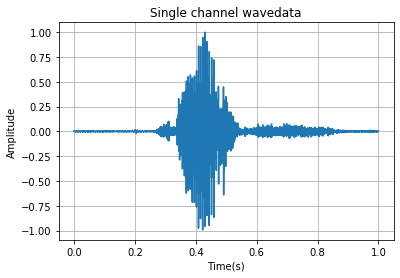

In [5]:
test_file = "{}/house/ad89eb1e_nohash_0.wav".format(DATA_DIR)

with wave.open(test_file, 'rb') as f:
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
#     print(nchannels, sampwidth, framerate, nframes) # 1 2 16000 16000
    strData = f.readframes(nframes)#读取音频，字符串格式
#     print(type(strData)) # <class 'bytes'>
#     print(strData[:20]) # b'\xff\xff\xea\xff\xe3\xff\xef\xff\xf6

waveData = np.fromstring(strData, dtype=np.int16)#将字符串转化为int
# print(type(waveData)) # <class 'numpy.ndarray'>
# print(waveData[:20]) # [ -1 -22 -29 -17 -10 -14 -19 -18 -18 -21 -11 8]

waveData_norm = waveData * 1.0 / (max(abs(waveData)))#wave幅值归一化
#     print(type(waveData_norm)) #<class 'numpy.ndarray'>
#     print(waveData_norm[:20]) #[-0.00010379 -0.00228334 -0.00300986 -0.0017644]
# print(waveData_norm.shape) # (16000,)

time = np.arange(0, nframes)*(1.0 / framerate)
plt.plot(time, waveData_norm)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Single channel wavedata")
plt.grid('on')
plt.show()

In [0]:
print(waveData_norm)
type(waveData_norm)

[0.00211277 0.00184867 0.00264096 ... 0.00316915 0.00316915 0.0035653 ]


numpy.ndarray

In [0]:
def get_wave_norm(file):
    with wave.open(file, 'rb') as f:
        params = f.getparams()
        nchannels, sampwidth, framerate, nframes = params[:4]
        data = f.readframes(nframes)
    data = np.fromstring(data, dtype=np.int16)
    data = data * 1.0 / max(abs(data))
    return data

def save_wave(data, file='./save.wav'):
    with wave.open(file, 'wb') as outwave:
        nchannels = 1
        sampwidth = 2
        framerate = 16000
        nframes = data.shape[0]
        comptype = "NONE"
        compname = "not compressed"
        outwave.setparams((nchannels, sampwidth, framerate, nframes, comptype, compname))

        for v in data:
            outwave.writeframes(struct.pack('h', int(v * 64000 / 2)))#outData:16位，-32767~32767，注意不要溢出

In [7]:
MAX_FRAME = 16000
LABELS = ['five', 'happy', 'one', 'house', 'tree', 'bed', 'marvin', 'dog', 'left', 'stop', 'sheila', 
          'four', 'zero', 'cat', 'three', 'two', 'bird', 'yes', 'wow', 'seven', 'on', 'down', 'nine', 
          'right', 'up', 'no', 'eight', 'six', 'off', 'go','follow','visual','backward','forward','learn']
N_CLASS = len(LABELS)

file_glob, noise_glob = [], []
for f in glob('{}/*/*.wav'.format(DATA_DIR)):
    # bug, this wav has no sound
    if f.find('bird/3e7124ba_nohash_0.wav') != -1: #Buang file bug pada bird/3e7124ba_nohash_0.wav ( tidak ada suara )
        continue
    
    if f.find('/_background_noise_/') == -1:
        file_glob.append(f)
    else:
        noise_glob.append(f)

noize_data = [get_wave_norm(f) for f in noise_glob]
noize_data = np.concatenate(noize_data, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [0]:
def add_noise(w):
    idx = random.randint(0, noize_data.shape[0] - w.shape[0])
    w = w + noize_data[idx:idx+w.shape[0]] / 5.0
    w = w * 1.0 / (max(abs(w)))
    return w

def get_wave(file):
    data = get_wave_norm(file)
    
    #if random.random() >= 0.5: #random noise
    #   data = add_noise(data) #tambahkan noise ke data

    wave_data = np.zeros((MAX_FRAME, ))
    wave_len = min(MAX_FRAME, data.shape[0])
    wave_data[:wave_len] = data[:wave_len]
    
    return np.expand_dims(wave_data, axis=1)

# test
# x = get_wave('{}/bed/0a7c2a8d_nohash_0.wav'.format(DATA_DIR))
# save_wave(x[:,0], 'mix.wav')

def gen(batch_size=32, verbose=False):
    while True:
        X = np.zeros((batch_size, MAX_FRAME, 1), dtype=np.float32)
        #y = np.zeros((batch_size, N_CLASS), dtype=np.uint8) #edit
        y = np.empty((batch_size), dtype=int)

        files = np.random.choice(file_glob, batch_size)
        if verbose:
            print(files)
            
        for i in range(batch_size):
            f = files[i]
            X[i] = get_wave(f)
            
            label = f[len(DATA_DIR) + 1:]
            label = label[:label.index('/')]
            label_idx = LABELS.index(label)
#            y[i, label_idx] = 1 #edit "#" untuk rnn saja
            y[i] = label_idx
        yield X, y

In [0]:
files = np.random.choice(file_glob, 1)
Z = get_wave(files[0])
print(Z)
type(Z)

[[-0.00046412]
 [ 0.00076317]
 [ 0.00039814]
 ...
 [-0.00775561]
 [-0.0080891 ]
 [-0.00905477]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


numpy.ndarray

In [0]:
# class AudioEvaluator(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print('*******')
#         X_test, y_test = next(gen(1, verbose=True)) # (1, 128, 128, 1)
#         y_pred = self.model.predict(X_test) # (1, 128, 128, AB_PAIRS)
#         print("predict:{}\n*******".format(LABELS[np.argmax(y_pred[0])]))

# evaluator = AudioEvaluator()

import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate

def do_train(m):
    global RUN
    RUN += 1
    print("RUN {}".format(RUN))

    LOG_DIR = '/output/training_logs/run-{}'.format(RUN)
    LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

    # tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, write_grads=False, write_graph=False)
    tensorboard = TensorBoard(log_dir=LOG_DIR, write_graph=True)
    checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=100, verbose=1)
    lrate = LearningRateScheduler(step_decay)

    history = m.fit_generator(generator=gen(32), steps_per_epoch=256,
                              validation_data=gen(32), validation_steps=16,
                              epochs=1000, verbose=1, use_multiprocessing=True, 
                              callbacks=[tensorboard, checkpoint, early_stopping, lrate])

# CNN

In [0]:
def get_conv_model():
    m = Sequential()
    m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(MAX_FRAME,1)))
    m.add(BatchNormalization())
    m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
    m.add(BatchNormalization())
#     m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
#     m.add(BatchNormalization())
    m.add(Flatten())
#     m.add(GlobalAveragePooling1D())
    m.add(Dropout(0.3))
    m.add(Dense(N_CLASS, activation='softmax'))
    m.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return m

In [0]:
def ConvSpeechModel(samplingrate = 16000, inputLength = 16000):
    """
    Base fully convolutional model for speech recognition
    """

    inputs = Input(shape=(inputLength,1))

    x = Reshape((1, -1)) (inputs)

    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, inputLength),
                             padding='same', sr=samplingrate, n_mels=80,
                             fmin=40.0, fmax=samplingrate/2, power_melgram=1.0,
                             return_decibel_melgram=True, trainable_fb=False,
                             trainable_kernel=False,
                             name='mel_stft') (x)
    
    x = Normalization2D(int_axis=0)(x)
    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs

    x = Permute((2,1,3)) (x)
    #x = Reshape((94,80)) (x) #this is strange - but now we have (batch_size, sequence, vec_dim)

    c1 = Conv2D(20, (5,1) , activation='relu', padding='same') (x)
    c1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 1)) (c1)
    p1 = Dropout(0.03) (p1)

    c2 = Conv2D(40, (3,3) , activation='relu', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(0.01) (p2)

    c3 = Conv2D(80, (3,3) , activation='relu', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    p3 = Flatten()(p3)
    p3 = Dense(64, activation = 'relu')(p3)
    p3 = Dense(32, activation = 'relu')(p3)

    output = Dense(N_CLASS, activation = 'softmax')(p3)
    model = Model(inputs=[inputs], outputs=[output], name='ConvSpeechModel')
    model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
    
    return model

In [0]:
m = ConvSpeechModel()
m.summary()
do_train(m)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "ConvSpeechModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 125, 80, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 80, 20)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


Changing learning rate to 0.001
256/256 [==============================] - 38s 148ms/step - loss: 3.5020 - sparse_categorical_accuracy: 0.0626 - val_loss: 3.3066 - val_sparse_categorical_accuracy: 0.0801


Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.08008, saving model to /output/training_logs/run-2/checkpoint-01-3.3066.hdf5
Epoch 2/1000
Changing learning rate to 0.001
256/256 [==============================] - 32s 124ms/step - loss: 3.1822 - sparse_categorical_accuracy: 0.1140 - val_loss: 3.0596 - val_sparse_categorical_accuracy: 0.1348

Epoch 00002: val_sparse_categorical_accuracy improved from 0.08008 to 0.13477, saving model to /output/training_logs/run-2/checkpoint-02-3.0596.hdf5
Epoch 3/1000
Changing learning rate to 0.001
256/256 [==============================] - 32s 127ms/step - loss: 2.8563 - sparse_categorical_accuracy: 0.1683 - val_loss: 2.7567 - val_sparse_categorical_accuracy: 0.1621

Epoch 00003: val_sparse_categorical_accuracy improved from 0.13

# CNN & RNN

In [0]:
def get_cnn_rnn_model():
    ipt = Input(shape=(MAX_FRAME, 1))
    x = ipt
    x = Conv1D(filters=128, kernel_size=50, strides=2, padding='valid', activation='relu')(x)
    x = Conv1D(filters=128, kernel_size=50, strides=2, padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # LSTM
    x = LSTM(64)(x)
    
    # double
#    x = LSTM(128, return_sequences=True)(x)
#    x = LSTM(64)(x)
    
    # 正反
#     r   = LSTM(32, return_sequences=True, go_backwards=False)(x)
#     r_b = LSTM(32, return_sequences=True, go_backwards=True)(x)
#    x = concatenate([r, r_b])
#    x = Flatten()(x)

    x = Dense(64)(x)
    x = Dropout(0.3)(x)
    x = Dense(N_CLASS, activation='softmax')(x)
    
    m = Model(inputs=[ipt], outputs=[x])
    m.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
    
    return m

# get_cnn_rnn_model().summary()

In [0]:
def RNNSpeechModel(samplingrate = 16000, inputLength = 16000):
    #simple LSTM
    sr = samplingrate
    iLen = inputLength
    
    inputs = Input(shape=(iLen,1))

    x = Reshape((1, -1)) (inputs)

    x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                             padding='same', sr=sr, n_mels=80,
                             fmin=40.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=True, trainable_fb=False,
                             trainable_kernel=False,
                             name='mel_stft') (x)

    x = Normalization2D(int_axis=0)(x)

    #note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    #we would rather have it the other way around for LSTMs

    x = Permute((2,1,3)) (x)

    x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)
    x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
    x = BatchNormalization() (x)

    #x = Reshape((125, 80)) (x)
    x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

    x = Bidirectional(CuDNNLSTM(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]
    x = Bidirectional(CuDNNLSTM(64)) (x)

    x = Dense(64, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dense(N_CLASS, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[x])
    model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
    
    return model

In [0]:
# LSTM without data augumentation[Best Model]Acc:68%
m = get_cnn_rnn_model()
m.summary()
#do_train(m)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7976, 128)         6528      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3964, 128)         819328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 3964, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

In [0]:
# LSTM paper 2018
m = RNNSpeechModel()
m.summary()
do_train(m)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 16000, 1)          0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_9 (Normaliza (None, 80, 125, 1)        0         
_________________________________________________________________
permute_9 (Permute)          (None, 125, 80, 1)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 80, 10)       60        
_________________________________________________________________
batch_normalization_19 (Batc (None, 125, 80, 10)       40 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


Changing learning rate to 0.001
256/256 [==============================] - 49s 193ms/step - loss: 3.4727 - sparse_categorical_accuracy: 0.0553 - val_loss: 3.2995 - val_sparse_categorical_accuracy: 0.0957

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.09570, saving model to /output/training_logs/run-10/checkpoint-01-3.2995.hdf5
Epoch 2/1000
Changing learning rate to 0.001
256/256 [==============================] - 42s 165ms/step - loss: 2.6719 - sparse_categorical_accuracy: 0.2330 - val_loss: 2.2665 - val_sparse_categorical_accuracy: 0.3262

Epoch 00002: val_sparse_categorical_accuracy improved from 0.09570 to 0.32617, saving model to /output/training_logs/run-10/checkpoint-02-2.2665.hdf5
Epoch 3/1000
Changing learning rate to 0.001
256/256 [==============================] - 44s 171ms/step - loss: 1.8051 - sparse_categorical_accuracy: 0.4746 - val_loss: 1.5732 - val_sparse_categorical_accuracy: 0.5312

Epoch 00003: val_sparse_categorical_accuracy improved from 0.3

In [0]:
%load_ext tensorboard
#LOG_DIR = '/output/training_logs/run-{}'.format(RUN)
%tensorboard --logdir LOG_DIR

In [0]:
tf.__version__

'1.15.0'